# Практическая работа №2

## Тема: Анализ логов

Выполнил Искяндяров Ильдар Тагирович
группа ББМО-01-23

Вариант №4: 19 mod 16 + 1 = 4


### Клонирование репозитория с логами для их последующего анализа

In [1]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 575 (delta 146), reused 136 (delta 133), pack-reused 401 (from 1)
Receiving objects: 100% (575/575), 7.27 MiB | 10.00 MiB/s, done.
Resolving deltas: 100% (267/267), done.


### Задание регулярного выражения для парсинга логов

Пояснение к регулярному выражению:

Для примера возьмем строчку из логов HDFS (Hadoop Distributed File System):

```
081109 203615 148 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_38865049064139660 terminating
```

Регулярное выражение извлекает все поля записи лога и делит его на следующие группы:

- Дата  в формате `DDMMYY`: `(\d{6})`
- Время в формате `HHMMSS`: `(\d{6})`
- PID - ID процесса, целое число: `(\d*?)`
- Уровень логирования - 6 возможных типов (`FATAL, ERROR, WARN, INFO, DEBUG и TRACE`): (`INFO|WARN|ERROR|FATAL|DEBUG|TRACE`)
- Компонент - имя компонента, создавшего запись в логе, отделённое от сообщения двоеточием: `(.*?):`
- Сообщение - непосредственное содержание записи, все символы до конца строки: `(.*)`

In [2]:
import re

pattern = r'(\d{6})\s(\d{6})\s(\d*?)\s(INFO|WARN|ERROR|TRACE|DEBUG)\s(.*?):\s(.*)'

### Инициализация базы данных

В среде выполнения создаётся каталог `./db`, где будет храниться файл базы данных SQLite

In [3]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")

In [4]:
import sqlite3

# путь к файлу с БД
db_path = './db/log-analysis.db'

# подключение к БД
connection = sqlite3.connect(db_path)
# создание курсора
cursor = connection.cursor()

# очистка БД, если таблица уже создана
cursor.execute("DROP TABLE IF EXISTS logs")
# создание таблицы
cursor.execute("CREATE TABLE logs (id INTEGER PRIMARY KEY AUTOINCREMENT, datetime text, pid int, msg_type text, component text, message text)")

# сохранение изменений
connection.commit()
# закрытие курсора
cursor.close()
# закрытие подключения к БД
connection.close()

### Парсинг лога и сохранение записей в БД

In [5]:
# подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# очистка таблицы во избежание дублирования данных
cursor.execute("DELETE FROM logs")

# парсинг файла с логом
with open('./loghub/HDFS/HDFS_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = re.match(pattern, line)
        if log_match:
            date = log_match.group(1)
            time = log_match.group(2)
            datetime = f"{date} {time}" # формирование полной даты по формату ISO8601
            pid = log_match.group(3)
            msg_type = log_match.group(4) # уровень логирования
            component = log_match.group(5)
            message = log_match.group(6)
            values = (datetime, pid, msg_type, component, message) # создание объекта для подстановки в SQL-запрос
            sql = "INSERT INTO logs (datetime, pid, msg_type, component, message) VALUES (?, ?, ?, ?, ?)"
            cursor.execute(sql, values) # запись данных в БД

connection.commit()
cursor.close()
connection.close()

### Чтение записей из БД

In [6]:
import pandas as pd

# подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# выборка всех записей из таблицы
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

cursor.close()
connection.close()

# запись данных в объект DataFrame
log_df = pd.DataFrame(rows, columns=("id", "Date","PID", "Log level", "Component", "Message"))
log_df

,id,Date,PID,Log level,Component,Message
0,1,081109 203615,148,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_38865049064139...
1,2,081109 203807,222,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_-6952295868487...
2,3,081109 204005,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...
3,4,081109 204015,308,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_82291938032499...
4,5,081109 204106,329,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-6670958622368...
...,...,...,...,...,...,...
1995,1996,081111 101621,24902,INFO,dfs.DataNode$DataXceiver,Receiving block blk_4198733391373026104 src: /...
1996,1997,081111 101735,26595,INFO,dfs.DataNode$PacketResponder,Received block blk_-5815145248455404269 of siz...
1997,1998,081111 101804,26494,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-295306975763175640 src: /...
1998,1999,081111 101954,26414,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_52257196770490...


### Построение графика распределения уровней логирования

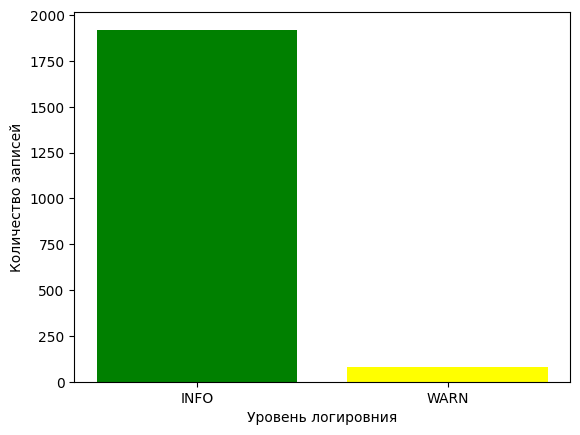

In [7]:
import matplotlib.pyplot as plt

# подсчёт записей с различными уровнями логирования
log_level_distrib = log_df['Log level'].value_counts()

x = log_level_distrib.keys()
y = log_level_distrib.values

# более подробные заголовки для графика
verbose_xticks = ["INFO", "WARN", "ERROR", "FATAL", "DEBUG", "TRACE"]

plt.xticks([0,1,2,3,4,5], verbose_xticks)
plt.xticks(rotation=0)
plt.xlabel('Уровень логировния')
plt.ylabel('Количество записей')
plt.bar(x,y)
plt.bar(x,y, color = ['green', 'yellow', 'red', 'darkred', 'blue', 'grey'])

plt.show()

### Построение графика распределения записей по компонентам, создавшим запись

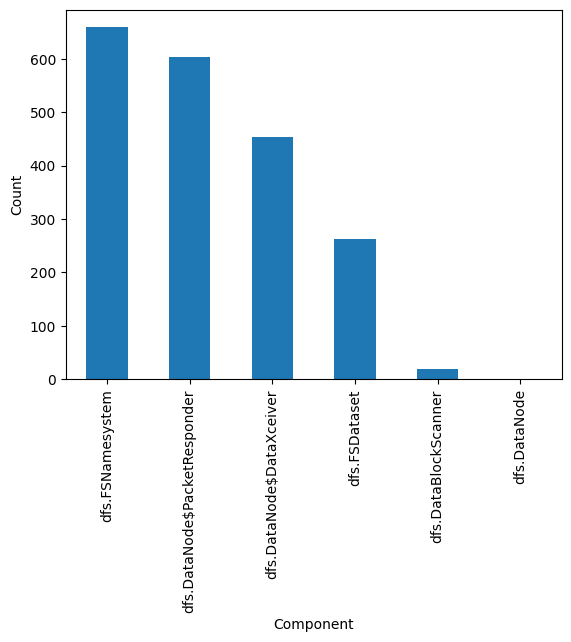

In [8]:
components_distrib = log_df['Component'].value_counts()

components_distrib.plot(kind='bar')

plt.xlabel('Component')
plt.ylabel('Count')
plt.show()

### Построение графика распределения предупреждений за время логирования (сообщений с уровнем логирования 'W')

<ipython-input-9-221758a7be83>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  warning_df['Date'] = pd.to_datetime(warning_df['Date'])
<ipython-input-9-221758a7be83>:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  warning_count = warning_count.resample('T').sum()


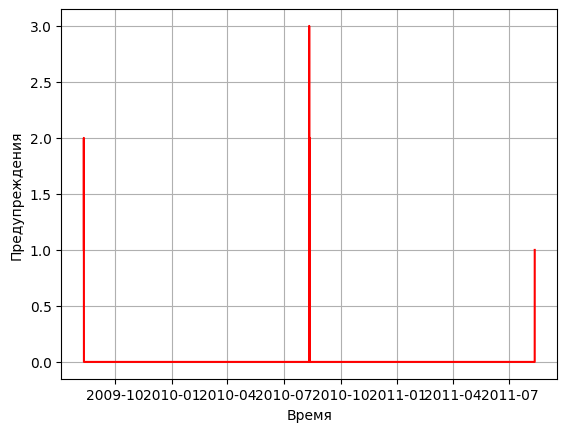

In [9]:
# выборка записей-предупреждений
warning_df = log_df[log_df['Log level'] == 'WARN'].copy()

# конвертация времени в объект datetime
warning_df['Date'] = pd.to_datetime(warning_df['Date'])

# группировка по времени
warning_count = warning_df.groupby('Date').size()

# ресэмплинг для группировки по целым секундам для наглядности
warning_count = warning_count.resample('T').sum()
warning_count = warning_count.fillna(0)

plt.plot(warning_count.index, warning_count.values, linestyle='-', color='r')
plt.xlabel('Время')
plt.ylabel('Предупреждения')
plt.grid(True)
plt.show()